In [1]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=9738923d18d7f2bf8212e4dedde6c497efaff67255edea33ac3b295b2138826a
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize_matplotlib


課題用スペクトル作成中...


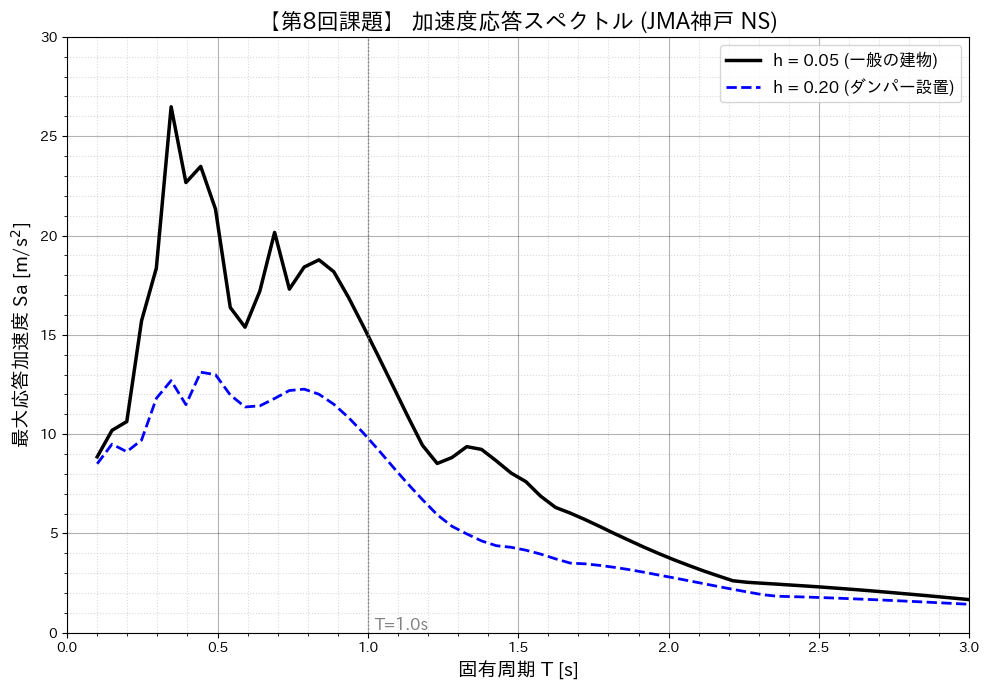

画像 'homework_spectrum.png' を保存しました。


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

# -----------------------------------------------------------------
# データ読み込み・解析関数 (変更なし)
# -----------------------------------------------------------------
def load_jma_kobe_data(filename="1995兵庫県南部地震_2.csv", component='NS'):
    with open(filename, 'r', encoding='shift_jis') as f:
        for i, line in enumerate(f):
            if i == 3:
                rate_str = line.split(',')[0].split('=')[1]
                dt = 1.0 / float(rate_str.replace('Hz', '').strip())
                break
    data = pd.read_csv(filename, skiprows=7, header=None, usecols=[0, 1, 2],
                       names=['NS', 'EW', 'UD'], encoding='shift_jis')
    data = data.fillna(0)
    ag = data[component].to_numpy(dtype=float)/100
    return ag, dt

def newmark_beta(m, c, k, p_force, dt, u0, v0, beta, gamma):
    n_steps = len(p_force)
    u = np.zeros(n_steps)
    v = np.zeros(n_steps)
    a = np.zeros(n_steps)
    u[0] = u0; v[0] = v0
    a[0] = (p_force[0] - c * v[0] - k * u[0]) / m
    a0 = 1.0 / (beta * dt**2); a1 = gamma / (beta * dt); a2 = 1.0 / (beta * dt)
    a3 = 1.0 / (2.0 * beta) - 1.0; a4 = gamma / beta - 1.0
    a5 = (dt / 2.0) * (gamma / beta - 2.0); a6 = dt * (1.0 - gamma); a7 = gamma * dt
    K_hat = k + a0 * m + a1 * c
    for i in range(n_steps - 1):
        P_hat = p_force[i+1] + m * (a0*u[i] + a2*v[i] + a3*a[i]) + c * (a1*u[i] + a4*v[i] + a5*a[i])
        u[i+1] = P_hat / K_hat
        a[i+1] = a0 * (u[i+1] - u[i]) - a2 * v[i] - a3 * a[i]
        v[i+1] = v[i] + a6 * a[i] + a7 * a[i+1]
    return np.arange(0, n_steps * dt, dt), u, v, a

# -----------------------------------------------------------------
# 課題用グラフ作成部
# -----------------------------------------------------------------
if __name__ == "__main__":
    try:
        ag, dt = load_jma_kobe_data()
    except:
        print("CSVファイルが必要です")
        exit()

    m = 1.0
    # ★課題用に h=0.05 (通常) と h=0.20 (高減衰) を計算
    h_list = [0.05, 0.20]
    T_list = np.linspace(0.1, 3.0, 60) # 読み取りやすいよう3秒まで

    spectrum = {h: [] for h in h_list}

    print("課題用スペクトル作成中...")
    for h in h_list:
        for Tn in T_list:
            wn = 2.0 * np.pi / Tn
            k = wn**2 * m
            c = 2.0 * h * wn * m
            p_force = -m * ag
            t, u, v, a = newmark_beta(m, c, k, p_force, dt, 0, 0, 1/4, 1/2)
            # 絶対加速度応答
            a_abs = ag + a
            spectrum[h].append(np.max(np.abs(a_abs)))

    # --- グラフ描画（配布プリント用） ---
    fig, ax = plt.figure(figsize=(10, 7)), plt.gca()

    # h=0.05
    ax.plot(T_list, spectrum[0.05], 'k-', linewidth=2.5, label='h = 0.05 (一般の建物)')
    # h=0.20
    ax.plot(T_list, spectrum[0.20], 'b--', linewidth=2.0, label='h = 0.20 (ダンパー設置)')

    # 読み取り補助線 (T=1.0s)
    ax.axvline(1.0, color='gray', linestyle=':', linewidth=1.0)
    ax.text(1.02, 0, 'T=1.0s', color='gray', fontsize=12, va='bottom')

    # グリッド（細かく入れて読みやすくする）
    ax.grid(which='major', color='black', linestyle='-', alpha=0.3)
    ax.minorticks_on()
    ax.grid(which='minor', color='gray', linestyle=':', alpha=0.3)

    ax.set_title('【第8回課題】 加速度応答スペクトル (JMA神戸 NS)', fontsize=16)
    ax.set_xlabel('固有周期 T [s]', fontsize=14)
    ax.set_ylabel('最大応答加速度 Sa [m/s$^2$]', fontsize=14)
    ax.set_xlim(0, 3.0)
    ax.set_ylim(0, 30)
    ax.legend(fontsize=12, loc='upper right')

    plt.tight_layout()
    plt.savefig('homework_spectrum.png', dpi=300)
    plt.show()
    print("画像 'homework_spectrum.png' を保存しました。")